# Regression

In [1]:
#!/usr/bin/env python3

# Basic import
import numpy as np
import matplotlib.pyplot as plt

# Pytorch import
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset, Subset
from torchvision import transforms, datasets
import torch.nn.functional as F


# Import models and training functions
from models import ConvNet, FFNet
from training import train_epoch, val_epoch
from functions import my_accuracy

# Import progress bars
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
from time import sleep

#Import sys
import sys

## Data generation

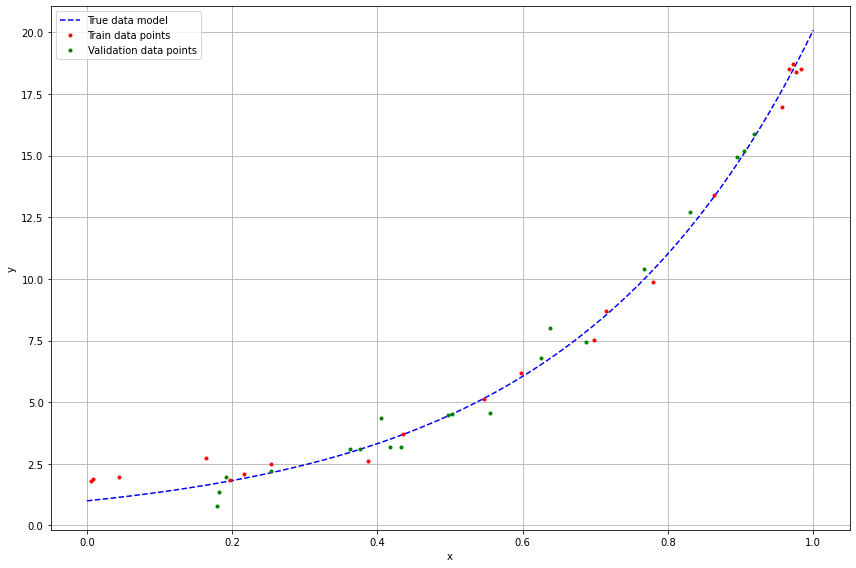

In [58]:
def exp_model(x, alpha, beta, noise_std=0):
    """
    INPUT
        x: x vector
        alpha: consant 
        beta: constant
        noise_std: enable noisy sampling (gaussian noise, zero mean, noise_std std)
    """
    noise = np.random.randn(len(x)) * noise_std
    return alpha*np.exp(beta*x) + noise

alpha = 1.0
beta = 3.0
noise_std = 0.5
np.random.seed(4)

### Train data
num_train_points = 20
x_train = np.random.rand(num_train_points)
y_train = exp_model(x_train, alpha, beta, noise_std)
with open('train_data.csv', 'w') as f:
    data = [f"{x},{y}" for x, y in zip(x_train, y_train)]
    f.write('\n'.join(data))
    
### Validation data
num_val_points = 20
x_val = np.random.rand(num_val_points)
y_val = exp_model(x_val, alpha, beta, noise_std)
with open('val_data.csv', 'w') as f:
    data = [f"{x},{y}" for x, y in zip(x_val, y_val)]
    f.write('\n'.join(data))

### Plot
plt.figure(figsize=(12,8))
x_highres = np.linspace(0,1,1000)
plt.plot(x_highres, exp_model(x_highres, alpha, beta), color='b', ls='--', label='True data model')
plt.plot(x_train, y_train, color='r', ls='', marker='.', label='Train data points')
plt.plot(x_val, y_val, color='g', ls='', marker='.', label='Validation data points')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

## Dataset and dataloader

### Dataset

In [59]:
class CsvDataset(Dataset):

    def __init__(self, csv_file, transform=None):
        """
        Args:
        csv_file (string): Path to the csv file.
        transform (callable, optional): Optional transform to be applied
            on a sample.
        """
        self.transform = transform
        
        # Read the file and split the lines in a list
        with open(csv_file, 'r') as f:
            lines = f.read().split('\n')
            
        # Get x and y values from each line and append to self.data
        self.data = []
        for line in lines:
            sample = line.split(',')
            self.data.append((float(sample[0]), float(sample[1])))
            # Now self.data contains all our dataset.
            # Each element of the list self.data is a tuple: (input, output)

    def __len__(self):
        # The length of the dataset is simply the length of the self.data list
        return len(self.data)

    def __getitem__(self, idx):
        # Our sample is the element idx of the list self.data
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample

### Transforms

In [60]:
class ToTensor(object):
    """Convert sample to Tensors."""

    def __call__(self, sample):
        x, y = sample
        return (torch.tensor([x]).float(),
                torch.tensor([y]).float())
    


In [61]:
composed_transform = transforms.Compose([ToTensor()])

train_dataset = CsvDataset('train_data.csv', transform=composed_transform)
val_dataset = CsvDataset('val_data.csv', transform=composed_transform)

### Dataloader


In [62]:
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_dataloader  = DataLoader(val_dataset,  batch_size=len(val_dataset), shuffle=False, num_workers=0)

## Define the Network


In [63]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cpu


In [71]:
# Define the network
layers_sizes = [1, 128, 256, 128, 1]

parameters1 = {
    "layers_sizes" : layers_sizes,
    "act" : nn.ReLU, 
    "optimizer" : optim.Adam, 
    "loss_fn" : nn.MSELoss(),
    "lr" : 0.001, 
    "weight_decay" : 0.0, 
    "drop_p" : 0.1,
    "momentum" : 0.0
}

parameters2 = {
    "layers_sizes" : layers_sizes,
    "act" : "ReLU", 
    "optimizer" : "RMSprop", 
    "loss_fn" : "MSELoss",
    "lr" : 0.001, 
    "weight_decay" : 0.0, 
    "drop_p" : 0.1,
    "momentum" : 0.0,
}

parameters3 = {
    "layers_sizes" : layers_sizes,
    "act" : "ReLU", 
    "optimizer" : "SGD", 
    "loss_fn" : "MSELoss",
    "lr" : 0.001, 
    "weight_decay" : 0.0, 
    "drop_p" : 0.1,
    "momentum" : 0.0,
}


# Set parameters used
parameters = parameters1

# Inizialize the network
torch.manual_seed(0)
net = FFNet(parameters)
net.to(device)



Network initialized


FFNet(
  (layers): ModuleList(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)

## Training

In [72]:
# Define the loss function
loss_function = parameters["loss_fn"]

# Define the optimizer
optimizer = parameters["optimizer"](net.parameters(), lr = parameters["lr"], weight_decay = parameters["weight_decay"])



In [73]:
### Training epochs

def train_epochs(max_num_epochs, early_stopping = True):
    
    # Pogress bar
    pbar = tqdm_notebook(range(max_num_epochs))

    # Inizialize empty lists to save losses
    train_loss_log = []
    val_loss_log = []
    accuracy = []

    for epoch_num in pbar:

        # Tran epoch
        mean_train_loss = train_epoch(net, device, train_dataloader, loss_function, optimizer)

        # Validate epoch
        mean_val_loss = val_epoch(net,  device, val_dataloader, loss_function)

        # Append losses and accuracy
        train_loss_log.append(mean_train_loss)
        val_loss_log.append(mean_val_loss)

        # Set pbar description
        pbar.set_description("Train loss: %s" %round(mean_train_loss,2)+", "+"Val loss %s" %round(mean_val_loss,2))
        
        # Early stopping
        if early_stopping:
            if np.mean(val_loss_log[-100:]) < val_loss_log[-10:]:
                print("Training stopped at epoch "+str(epoch_num)+" to avoid overfitting.")
                break
    
    return train_loss_log, val_loss_log
    

In [74]:
# Training
max_num_epochs = 1000
train_loss_log, val_loss_log = train_epochs(max_num_epochs, early_stopping = False)

  0%|          | 0/1000 [00:00<?, ?it/s]

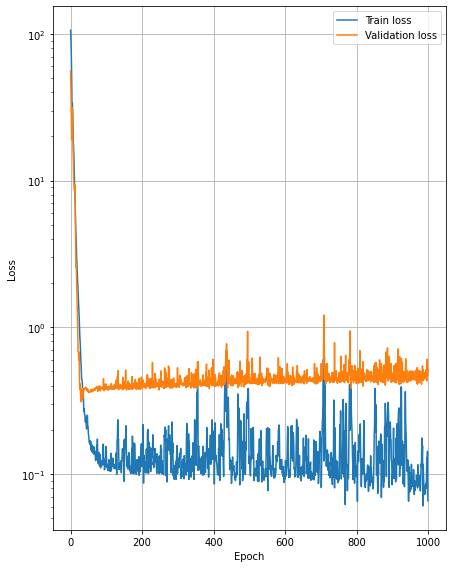

In [75]:
### Plot losses
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(121)
ax1.semilogy(train_loss_log, label='Train loss')
ax1.semilogy(val_loss_log, label='Validation loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()


plt.tight_layout()
plt.show()

## Save and Load model

In [76]:
### Save network parameters
net_name = "FFNet_basic.torch"

### Save the network state
# The state dictionary includes all the parameters of the network
net_dict = { "state" : net.state_dict(),
            "parameters" : parameters}
# Save the state dict to a file
torch.save(net_dict,net_name)



In [77]:
### Reload the network state

# Load the state dict previously saved
net_dict = torch.load(net_name)
net_state_dict = net_dict["state"]
net_parameters_dict = net_dict["parameters"]

# Redefine the network and upload parameters
net = FFNet(net_parameters_dict)
net.load_state_dict(net_state_dict)

Network initialized


<All keys matched successfully>

## Network Analysis

In [81]:
# Input vector
x_vec = torch.linspace(0,1,1000)
x_vec = x_vec.to(device)
x_vec = x_vec.unsqueeze(-1)
print(f"Input shape: {x_vec.shape}")

# Network output
with torch.no_grad():
    y_vec = net(x_vec)
print(f"Output shape: {y_vec.shape}")

# Expected output
true_model = exp_model(x_vec.cpu().numpy(), alpha, beta).squeeze()

Input shape: torch.Size([1000, 1])
Output shape: torch.Size([1000, 1])


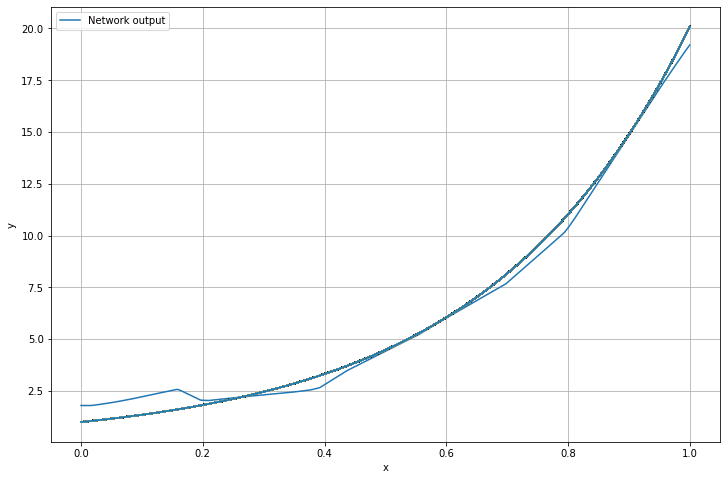

In [82]:
# Convert x_vec and y_vec to numpy one dimensional arrays
x_vec = x_vec.squeeze().cpu().numpy()
y_vec = y_vec.squeeze().cpu().numpy()

# Plot output
plt.figure(figsize=(12,8))
plt.plot(x_vec, y_vec, label='Network output')
plt.plot(x_vec, true_model)
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.show()